In [1]:
# Obtain the data
from dataset import load_spectral_data, dataset_dict_to_dense, augment_mix
import numpy as np

from scipy.signal import savgol_filter
with open("data2.txt") as f:
    sources = f.read().splitlines()
    sources = [ s for s in sources if not s.startswith("#")]
    dataset_dict = load_spectral_data(sources, verbose=True)

#del dataset_dict["012-6C-XXX-JB005-C002-veau_histo2_chair_2.Sample.asc"]
#del dataset_dict["012-6C-XXX-JB005-C001-veau_histo2_chair_1.Sample.asc"]
names = list(dataset_dict.keys())
# We label the dataset and convert it to numpy arrays
X, Y = dataset_dict_to_dense(dataset_dict)

# Build the wavelength vector
wavelength = np.flipud(np.linspace(250, 2500, 226))
# Wavelengths above 2300nm are removed because of low SNR
wl_mask = wavelength <= 2300
X = X[:, wl_mask]
wavelength = wavelength[wl_mask]

Loading 0 files from VALIDATION 12 13 15 16 19
Loading 115 files from ./raw_data/DataDavid/UVVIS/*.asc
Loading 360 files from ./raw_data/DataHenry23/Perkin/New_*/*.asc
Loading 43 files from ./raw_data/DataJulie/07_09_spectro/**/*.asc
Loading 24 files from ./raw_data/DataJulie/14_09_2023/*.asc
Loading 16 files from ./raw_data/DataJulie/11_09_2023/*.asc
Loading 13 files from ./raw_data/DataJulie/14_09_2023_histo/*.asc
Loading 21 files from ./raw_data/DataJulie/historique/*.asc
Loading 36 files from ./raw_data/DataNicolas/08_01_2024/*.asc
Loading 16 files from ./raw_data/DataNicolas/09_01_2024/*.asc
Loading 4 files from ./raw_data/DataNicolas/11_01_2024/015-*.asc
Loading 2 files from ./raw_data/DataNicolas/11_01_2024/016-*.asc
Loading 8 files from ./raw_data/DataNicolas/17_01_2024/017-*NR006*.asc
Loading 8 files from ./raw_data/DataNicolas/17_01_2024/017-*NR005*.asc
Loading 0 files from ./raw_data/DataNicolas/19_01_2024/018-*.asc


In [2]:
# Normalize the data
names = [ names[i] for i in range(len(names)) if Y[i,5] < 4]
X = X[Y[:,5]< 4,:]
Y = Y[Y[:,5]< 4,:]
Xraw = X.copy()
#X = savgol_filter(X, 20, 3, axis=-1)

dsmean = X.mean(axis=0)
dsstd = X.std(axis=0) * 2
X = (X - dsmean) / dsstd

64 236
[400. 390. 380. 370. 360. 350. 340. 330. 320. 310.]


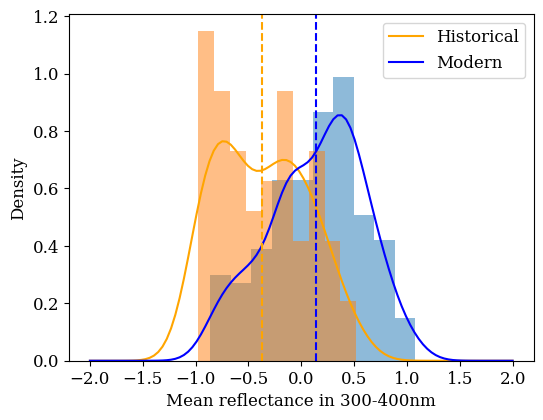

In [4]:
# Vizualize using PCA and t-SNE
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif'})
model = TSNE(2, perplexity=50)
#model = PCA(2)
X_tsne = model.fit_transform(X)
is_histo = (Y[:, 0] == 13) | (Y[:, 0] == 12) | (Y[:, 0] == 15) | (Y[:, 0] == 16) | (Y[:, 0] == 19)
print(np.count_nonzero(is_histo), len(is_histo))
fig, (ax2) = plt.subplots(1, 1, figsize=(6, 4.5))
#ax1.scatter(*X_tsne.T[:, ~is_histo], c=Y[~is_histo, 1], marker="o", alpha=0.9)#Y[:,5]
#ax1.scatter(*X_tsne.T[:, is_histo], c=Y[is_histo, 1], marker="x", alpha=0.9)#Y[:,5]
from scipy.stats import gaussian_kde
histo_kde = gaussian_kde(np.mean(X[is_histo, 190:200], axis=1))
modern_kde = gaussian_kde(np.mean(X[~is_histo, 190:200], axis=1))
ax2.hist(np.mean(X[~is_histo, 190:200], axis=1), bins=10, density=True, alpha=0.5)
ax2.hist(np.mean(X[is_histo, 190:200], axis=1), bins=10, density=True, alpha=0.5)
ax2.plot(np.linspace(-2, 2, 100), histo_kde(np.linspace(-2, 2, 100)), label="Historical", color="orange")
ax2.plot(np.linspace(-2, 2, 100), modern_kde(np.linspace(-2, 2, 100)), label="Modern", color="blue")
ax2.axvline(np.mean(X[~is_histo, 190:200]), color="blue", linestyle="--")
ax2.axvline(np.mean(X[is_histo, 190:200]), color="orange", linestyle="--")
ax2.set_xlabel("Mean reflectance in 300-400nm")
ax2.set_ylabel("Density")
#ax1.set_xlabel("t-SNE1")
#ax1.set_ylabel("t-SNE2")
plt.legend()
print(wavelength[190:200])
plt.savefig("histo_modern.png")
plt.savefig("histo_modern.pdf")

In [5]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self, in_features, complexity=2, latent_space=16, dropout=0.2, kernel_base=5):
        super(AutoEncoder, self).__init__()
        self.complexity = complexity
        self.in_features = in_features
        self.conv = nn.Sequential(
            nn.Conv1d(1, complexity*1, kernel_base+2, 3),
            nn.ReLU(),
            nn.Conv1d(complexity*1, complexity*2, kernel_base, 3),
            nn.Tanh(),
            nn.Dropout1d(dropout),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(complexity*2, complexity*1, kernel_base, 3),
            nn.ReLU(),
            nn.Dropout1d(dropout),
            nn.ConvTranspose1d(complexity*1, 1, kernel_base+2, 3),
            #nn.Tanh(),
            nn.Upsample(in_features)
        )

        #latent_size = self.conv(torch.randn(1, 1, in_features)).shape[-1]
        #self.l1 = nn.Linear(complexity*2*latent_size, latent_space)
        #self.l2 = nn.Linear(latent_space, complexity*2*latent_size)

    def forward(self, X):
        code = self.encode(X)
        return self.decode(code)
    def encode(self, X):
        bs = X.shape[0]
        X1 = self.conv(X)
        #X = torch.tanh(self.l1(X1.reshape(bs, -1)))
        return X1
    def decode(self, X):
        bs = X.shape[0]
        # X = torch.relu(self.l2(X).reshape(bs, self.complexity*2, -1))
        X = self.deconv(X)
        return X

ModuleNotFoundError: No module named 'torch'

In [399]:
from torch.utils.data import TensorDataset, DataLoader
from misc import count_parameters, torchify
from torch.optim import Adam
mask = Y[:, 1] > -1

loader = DataLoader(TensorDataset(torchify(X[mask], cc=1), torchify(Y[mask, 1], torch.long)), batch_size=12, shuffle=True)

In [400]:
from tqdm import trange
ae = AutoEncoder(X.shape[1], complexity=4, dropout=0, kernel_base=11)
optim = Adam(ae.parameters(), lr=1e-3, weight_decay=1e-3)
mse_loss = nn.MSELoss()

epoch_loss = 0.0
epochs = trange(200)
for e in epochs:
    for x, y in loader:
        optim.zero_grad()
        xr = ae(x)
        loss = mse_loss(x, xr)
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    epoch_loss /= len(loader)
    epochs.set_description(f"{epoch_loss:0.4f}")

0.0045:  68%|██████▊   | 135/200 [00:08<00:04, 15.23it/s]


KeyboardInterrupt: 

825


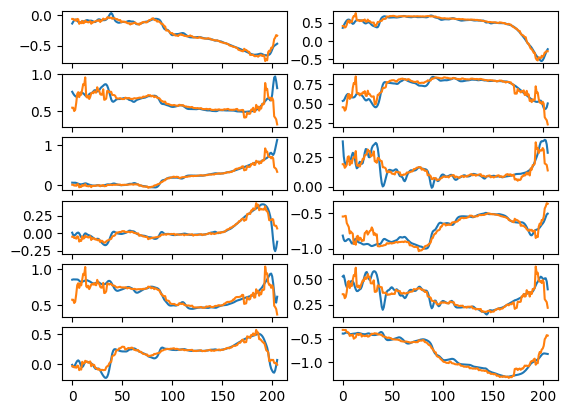

In [401]:
fig, axs = plt.subplots(len(x)//2, 2)
axs = axs.flatten()
for i, (xx, ax) in enumerate(zip(x, axs)):
    ax.plot(x[i, 0].detach().numpy())
    ax.plot(xr[i, 0].detach().numpy())
print(count_parameters(ae))



(214, 8, 19)


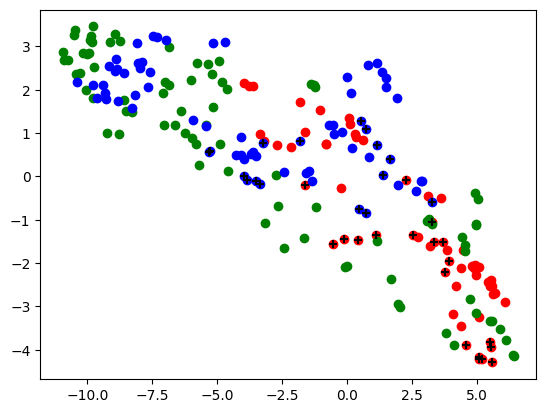

In [402]:
X_ae = ae.encode(torchify(X, cc=1)).detach().numpy()
print(X_ae.shape)
tsne_ae = TSNE(2, perplexity=60)
X_ae_tsne = tsne_ae.fit_transform(X_ae.reshape(-1, X_ae.shape[1]*X_ae.shape[2]))
colors = ["r", "g", "b"]
for i in range(3):
    plt.scatter(*X_ae_tsne[(Y[:, 1]==i)].T, c=colors[i])

plt.scatter(*X_ae_tsne[(Y[:, 0]==12)].T, marker="+", c="k")



In [403]:
print(np.arange(len(X_ae_tsne))[(X_ae_tsne[:, 0] > 3.) & (Y[:, 1]==0)])

[ 15  18  21  23  24  26  28  31  33  35  39  41  88  89  91  96 103 114
 125 127 128 129 130 132 135 136 138 144 150 155 159 200 206 207]


In [404]:
print(names[128], names[131])

012-1C-XXX-JB005-X002-histo1_veau_slide1_2.Sample.asc 012-5C-XXX-JB005-F001-couverture_veau_fleur_1.Sample.asc


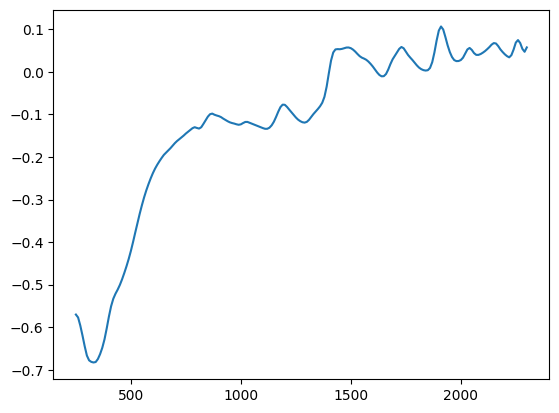

In [405]:
plt.plot(wavelength, X[131])

In [432]:
# Try to classify this latent space
class Classifier(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super(Classifier, self).__init__()
        self.s1 = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 3),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, X):
        return self.s1(X)
X_ae_lin = X_ae.reshape(214, -1)
print(X_ae_lin.shape)
print(Y.shape)

(214, 152)
(214, 6)


In [433]:
mask = (Y[:, 0] != 12) & (Y[:, 0] != 13)
labels = Y[mask, 1].copy()
#labels[Y[mask, 1]==2] = 1
model = TSNE(3, perplexity=30)
X_tsne2 = model.fit_transform(X)


loader = DataLoader(TensorDataset(torchify(X_tsne2[mask], cc=1), torchify(labels, torch.long)), batch_size=8, shuffle=True)

from tqdm import trange
cls = Classifier()
optim = Adam(cls.parameters(), lr=1e-3, weight_decay=1e-3)
nll_loss = nn.NLLLoss()

epoch_loss = 0.0
epochs = trange(180)
for e in epochs:
    for x, y in loader:
        optim.zero_grad()
        yp = cls(x[:, 0])
        loss = nll_loss(yp, y)
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    epoch_loss /= len(loader)
    epochs.set_description(f"{epoch_loss:0.4f}")

0.5792: 100%|██████████| 180/180 [00:01<00:00, 116.99it/s]


In [434]:
ph = cls(torch.from_numpy(X_tsne2[~mask]).type(torch.float)).detach().numpy()
print(ph.shape)
print(np.count_nonzero(np.argmax(ph, axis=1)==Y[~mask, 1])/ len(ph))

(56, 3)
0.6607142857142857


In [393]:
has_error = np.argmax(ph, axis=1)==Y[~mask, 1]
Xe = Xraw[~mask][has_error]
error_index = np.arange(len(names))[~mask][has_error]

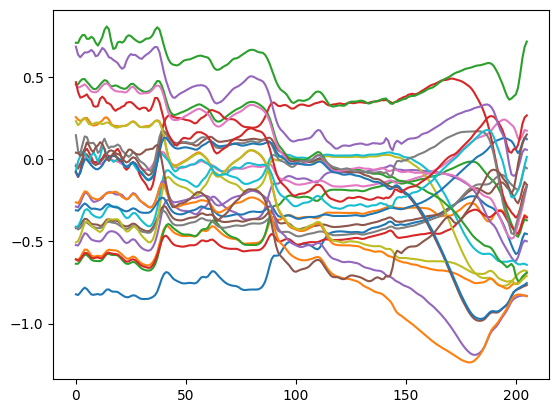

In [394]:
plt.plot(Xe.T)

In [395]:
for i in error_index:
    print(names[i])

012-8C-XXX-JB004-F001-veau2_fleur_1.Sample.asc
012-7C-XXX-JB004-F002-veau1_fleur_2.Sample.asc
012-8C-XXX-JB004-F002-veau2_fleur_2.Sample.asc
012-7C-XXX-JB004-F001-veau1_fleur_1.Sample.asc
012-2G-XXX-JB004-F001-chevre1_fleur_1.Sample.asc
012-7C-XXX-JB004-C001-veau1_chair_1.Sample.asc
012-8C-XXX-JB004-C002-veau2_chair_2.Sample.asc
012-7C-XXX-JB004-C002-veau1_chair_2.Sample.asc
012-1G-XXX-JB004-F001-chevre_PC2_fleur_1.Sample.asc
012-1G-XXX-JB004-F002-chevre_PC2_fleur_2.Sample.asc
012-8C-XXX-JB004-C001-veau2_chair_1.Sample.asc
013-6S-XXX-JB002-X001-msmeh8_side1_1.Sample.asc
013-5S-XXX-JB002-X002-msmeh7_side1_2.Sample.asc
013-1S-XXX-JB002-Y001-Hull_1568_side2.Sample.asc
013-6S-XXX-JB002-Y001-msmeh8_side2_1.Sample.asc
013-5S-XXX-JB002-Y002-msmeh7_side2_2.Sample.asc
013-5S-XXX-JB002-X001-msmeh7_side1_1.Sample.asc
013-2S-XXX-JB002-Y001-Hull_1652_side2.Sample.asc
013-6S-XXX-JB002-X002-msmeh8_side1_2.Sample.asc
013-4S-XXX-JB002-Y001-Hull_1870_side2.Sample.asc
013-5S-XXX-JB002-Y001-msmeh7_side2_1

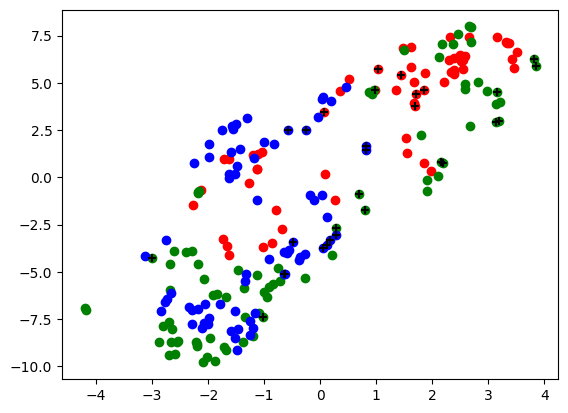

In [366]:
colors = ["r", "g", "b"]
for i in range(3):
    plt.scatter(*X_ae_tsne[(Y[:, 1]==i)].T, c=colors[i])

plt.scatter(*X_ae_tsne[error_index].T, marker="+", c="k")

